Import Required Libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import joblib
import warnings
warnings.filterwarnings('ignore')

Read Data and Store it in DataFrame:

In [3]:
df = pd.read_csv("lead_management_dataset.csv")
df.shape

(1200, 9)

In [4]:
df.head()

,inquiry_type,project_type,service_needed,budget_range,project_timeline,city,preferred_contact,message_length,lead_score
0,Dealership Inquiry,Residential,Special Effects & Textures,"Below ₹10,000",1-4 Weeks,Bengaluru,WhatsApp,154,0
1,Bulk Order Inquiry,Residential,Color Consultation,"₹50,000 - ₹2,00,000",1-3 Months,Delhi,Email,56,0
2,Dealership Inquiry,Commercial,Professional Painting,"Below ₹10,000",Urgent (Within 1 Week),Kochi,WhatsApp,319,1
3,Product Inquiry,Industrial,Exterior Solutions,"₹2,00,000 - ₹10,00,000",1-3 Months,Pune,Phone,121,1
4,Product Inquiry,Commercial,Color Consultation,"Above ₹10,00,000",1-4 Weeks,Pune,Phone,87,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   inquiry_type       1200 non-null   object
 1   project_type       1200 non-null   object
 2   service_needed     1200 non-null   object
 3   budget_range       1200 non-null   object
 4   project_timeline   1200 non-null   object
 5   city               1200 non-null   object
 6   preferred_contact  1200 non-null   object
 7   message_length     1200 non-null   int64 
 8   lead_score         1200 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 84.5+ KB


In [6]:
df.describe()

,message_length,lead_score
count,1200.000000,1200.000000
mean,195.777500,0.348333
std,90.420838,0.520150
min,40.000000,0.000000
25%,116.000000,0.000000
50%,194.000000,0.000000
75%,274.250000,1.000000
max,350.000000,2.000000


Exploratory Data Analysis

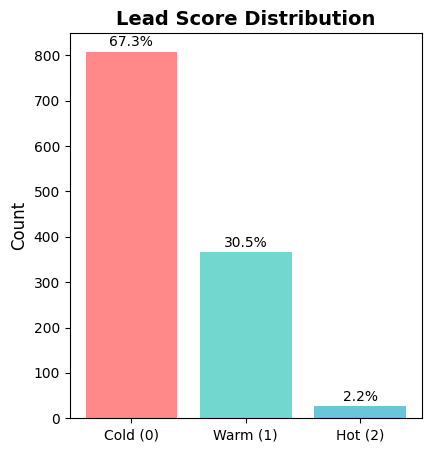

In [7]:
# 1. Distribution of lead scores
plt.figure(figsize=(10, 5))
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']

plt.subplot(1, 2, 1)
score_counts = df['lead_score'].value_counts()
bars = plt.bar(['Cold (0)', 'Warm (1)', 'Hot (2)'], score_counts.values, color=colors, alpha=0.8)
plt.title('Lead Score Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=12)

total = sum(score_counts.values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
    f'{height/total*100:.1f}%', ha='center', va='bottom', fontsize=10)

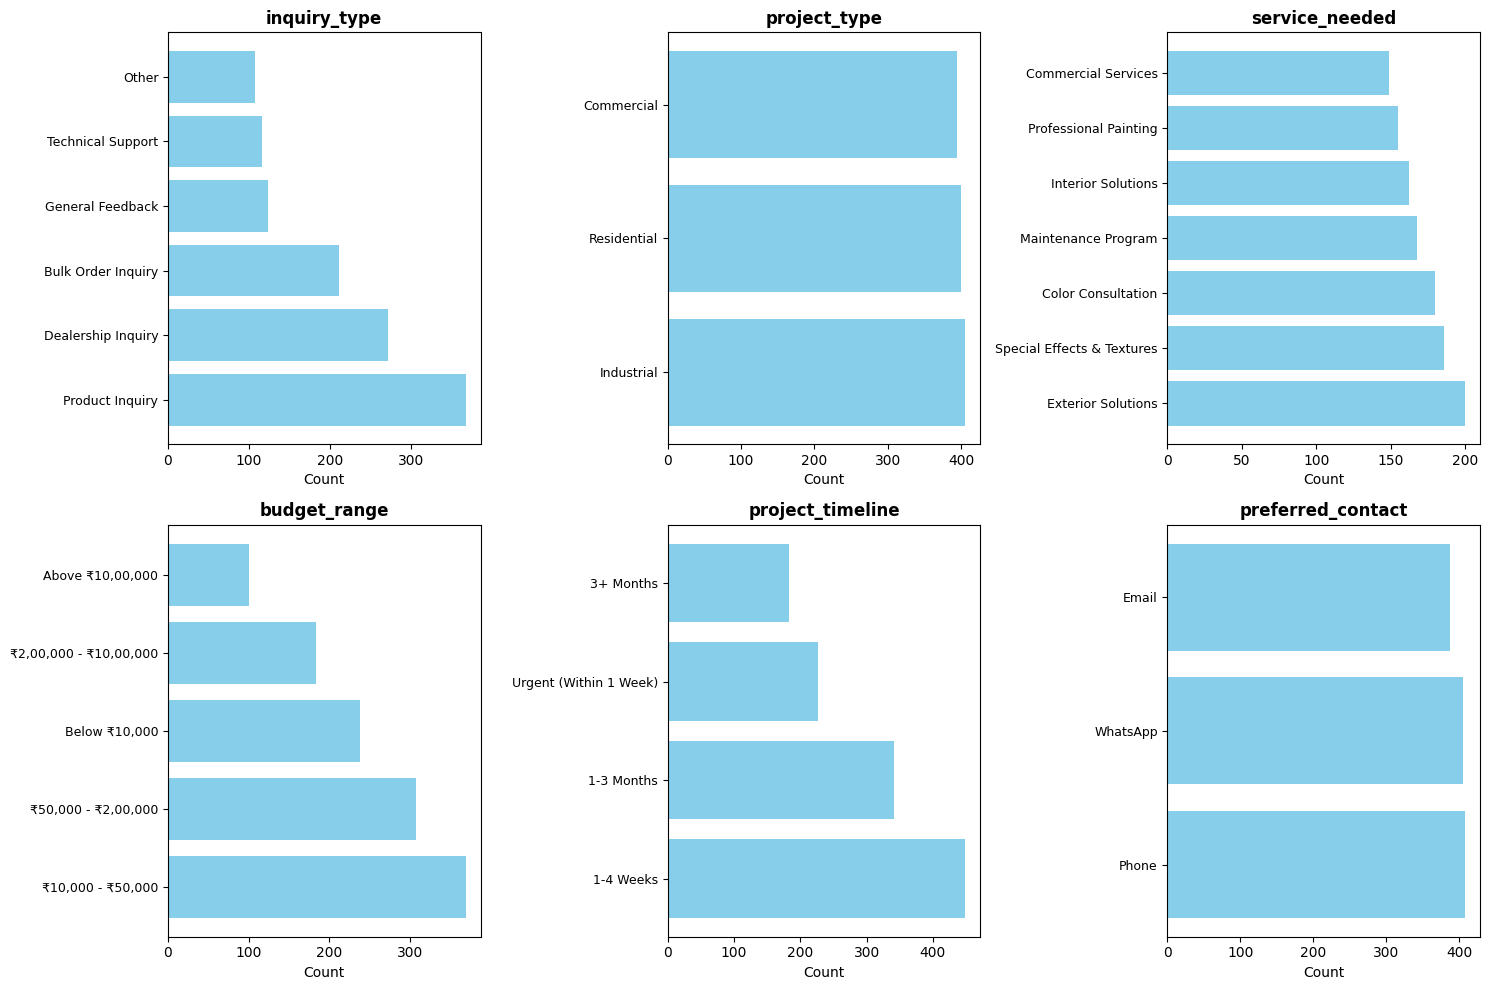

In [8]:
# 2. Feature distributions
categorical_features = ['inquiry_type', 'project_type', 'service_needed', 'budget_range', 'project_timeline', 'preferred_contact']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
   counts = df[feature].value_counts()
   axes[idx].barh(range(len(counts)), counts.values, color='skyblue')
   axes[idx].set_yticks(range(len(counts)))
   axes[idx].set_yticklabels(counts.index, fontsize=9)
   axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
   axes[idx].set_xlabel('Count')

plt.tight_layout()

<Figure size 1200x600 with 0 Axes>

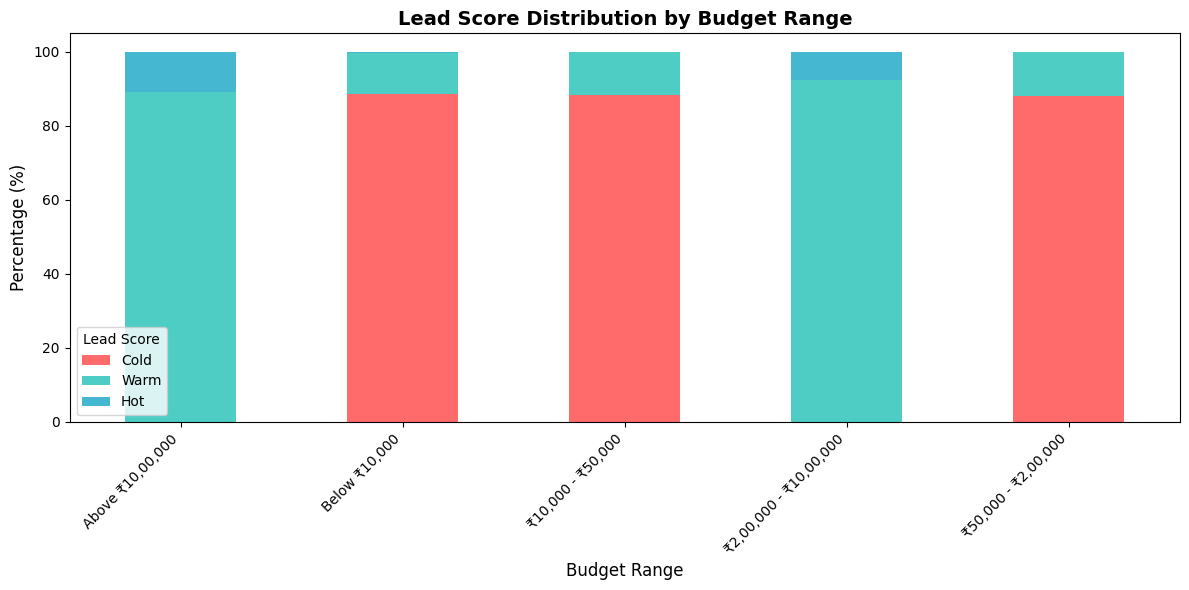

In [9]:
# 3. Budget vs Lead Score
plt.figure(figsize=(12, 6))

budget_lead = pd.crosstab(df['budget_range'], df['lead_score'], normalize='index') * 100

budget_lead.plot(kind='bar', stacked=True, color=colors, figsize=(12, 6))
plt.title('Lead Score Distribution by Budget Range', fontsize=14, fontweight='bold')
plt.xlabel('Budget Range', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(['Cold', 'Warm', 'Hot'], title='Lead Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

<Figure size 1000x600 with 0 Axes>

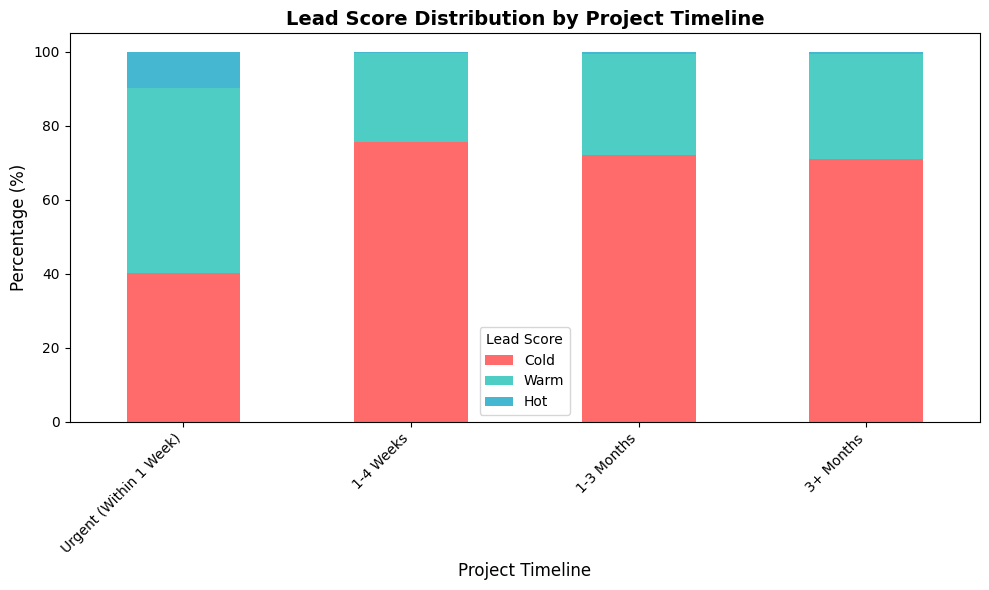

In [10]:
# 4. Timeline vs Lead Score
plt.figure(figsize=(10, 6))

timelines = ['Urgent (Within 1 Week)', '1-4 Weeks', '1-3 Months', '3+ Months']
timeline_lead = pd.crosstab(df['project_timeline'], df['lead_score'], normalize='index') * 100

timeline_lead = timeline_lead.reindex(timelines)
timeline_lead.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))
plt.title('Lead Score Distribution by Project Timeline', fontsize=14, fontweight='bold')
plt.xlabel('Project Timeline', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(['Cold', 'Warm', 'Hot'], title='Lead Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

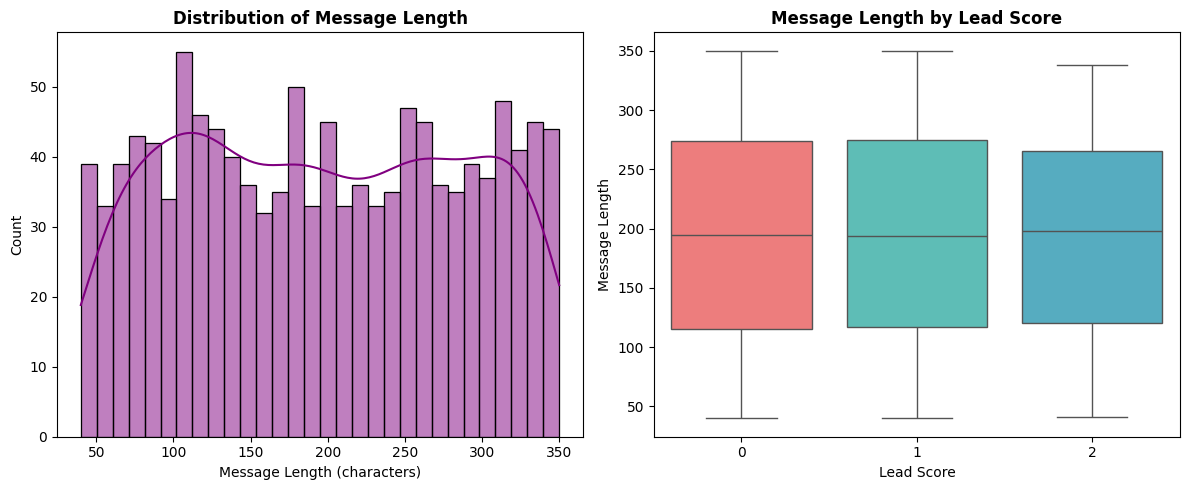

In [11]:
# 5. Message Length Analysis
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['message_length'], bins=30, kde=True, color='purple')
plt.title('Distribution of Message Length', fontsize=12, fontweight='bold')
plt.xlabel('Message Length (characters)')

plt.subplot(1, 2, 2)
sns.boxplot(x='lead_score', y='message_length', data=df, palette=colors)
plt.title('Message Length by Lead Score', fontsize=12, fontweight='bold')
plt.xlabel('Lead Score')
plt.ylabel('Message Length')
plt.tight_layout()

Data Preprocessing:

In [12]:
# Create a copy of the dataframe
df_processed = df.copy()

In [13]:
# 1. Map budget ranges to numeric values
budget_mapping = {
'Below ₹10,000': 1,
'₹10,000 - ₹50,000': 2,
'₹50,000 - ₹2,00,000': 3,
'₹2,00,000 - ₹10,00,000': 4,
'Above ₹10,00,000': 5
}
df_processed['budget_numeric'] = df_processed['budget_range'].map(budget_mapping)

In [14]:
# 2. Map timeline to urgency score
timeline_mapping = {
'3+ Months': 1,
'1-3 Months': 2,
'1-4 Weeks': 3,
'Urgent (Within 1 Week)': 4
}
df_processed['urgency_score'] = df_processed['project_timeline'].map(timeline_mapping)

In [15]:
# 3. Create binary features
df_processed['is_commercial'] = df_processed['project_type'].isin(['Commercial', 'Industrial']).astype(int)
df_processed['is_high_value_inquiry'] = df_processed['inquiry_type'].isin(['Bulk Order Inquiry', 'Dealership Inquiry']).astype(int)
df_processed['detailed_message'] = (df_processed['message_length'] > 200).astype(int)

In [16]:
# 4. Label encode categorical variables
categorical_cols = ['inquiry_type', 'project_type', 'service_needed', 'city', 'preferred_contact']

label_encoders = {}
for col in categorical_cols:
   le = LabelEncoder()
   df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
   label_encoders[col] = le

In [17]:
# 5. Prepare feature matrix and target
features = ['budget_numeric', 'urgency_score', 'is_commercial','is_high_value_inquiry', 'detailed_message', 'message_length']

In [18]:
# Add encoded categorical features
encoded_features = [col + '_encoded' for col in categorical_cols]
features.extend(encoded_features)

In [19]:
# Preprocessed data
X = df_processed[features]
y = df_processed['lead_score']

Split the Data before Training and Testing:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
# Scale numeric features
scaler = StandardScaler()
numeric_cols = ['budget_numeric', 'urgency_score', 'message_length']

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features used: {len(features)}")

Training set: (960, 11)
Test set: (240, 11)
Features used: 11


Model Training:

In [22]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    # Train model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    results[name] = {
    'model': model,
    'accuracy': accuracy,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'predictions': y_pred
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")


Training Logistic Regression...
  Accuracy: 0.8292
  CV Score: 0.8438 (+/- 0.0401)

Training Random Forest...
  Accuracy: 0.9792
  CV Score: 0.9771 (+/- 0.0214)

Training Gradient Boosting...
  Accuracy: 0.9792
  CV Score: 0.9750 (+/- 0.0222)


Model Evaluation:

In [23]:
# 1. Compare model performances
print("\n1. MODEL COMPARISON:")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'CV Mean Score': [results[m]['cv_mean'] for m in results.keys()],
    'CV Std': [results[m]['cv_std'] for m in results.keys()]
})

print(comparison_df.sort_values('Accuracy', ascending=False))


1. MODEL COMPARISON:
                 Model  Accuracy  CV Mean Score    CV Std
1        Random Forest  0.979167       0.977083  0.010725
2    Gradient Boosting  0.979167       0.975000  0.011122
0  Logistic Regression  0.829167       0.843750  0.020037


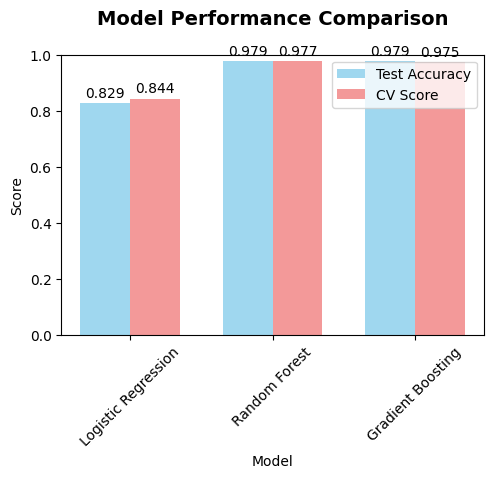

In [24]:
# 2. Visualize model performance
plt.figure(figsize=(12, 8))

# Accuracy comparison
plt.subplot(2, 2, 1)
models_list = list(results.keys())
accuracies = [results[m]['accuracy'] for m in models_list]
cv_scores = [results[m]['cv_mean'] for m in models_list]

x = np.arange(len(models_list))
width = 0.35

plt.bar(x - width/2, accuracies, width, label='Test Accuracy', color='skyblue', alpha=0.8)
plt.bar(x + width/2, cv_scores, width, label='CV Score', color='lightcoral', alpha=0.8)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison\n', fontsize=14, fontweight='bold')
plt.xticks(x, models_list, rotation=45)
plt.legend()
plt.ylim(0, 1.0)

# Add value labels
for i, v in enumerate(accuracies):
   plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center')
for i, v in enumerate(cv_scores):
   plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center')

Text(0.5, 23.52222222222222, 'Predicted')

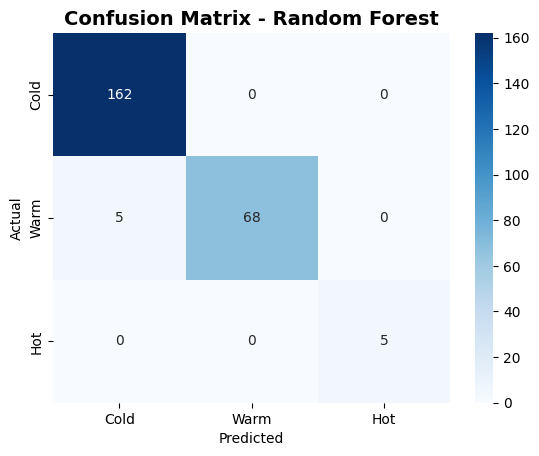

In [25]:
# 3. Confusion Matrix for best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
y_pred = results[best_model_name]['predictions']

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
xticklabels=['Cold', 'Warm', 'Hot'],
yticklabels=['Cold', 'Warm', 'Hot'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')

Text(0.5, 1.0, 'Classification Report - Random Forest')

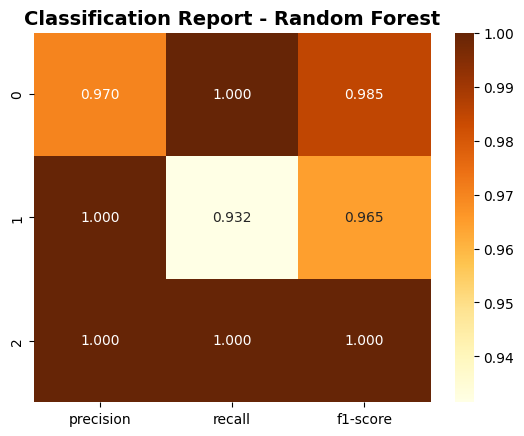

In [26]:
# 4. Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:3]

sns.heatmap(report_df[['precision', 'recall', 'f1-score']], 
annot=True, cmap='YlOrBr', fmt='.3f')
plt.title(f'Classification Report - {best_model_name}', fontsize=14, fontweight='bold')

In [27]:
# 5. Detailed classification report
print(f"\nDETAILED REPORT FOR BEST MODEL ({best_model_name}):\n")
print(classification_report(y_test, y_pred, target_names=['Cold Lead', 'Warm Lead', 'Hot Lead']))


DETAILED REPORT FOR BEST MODEL (Random Forest):

              precision    recall  f1-score   support

   Cold Lead       0.97      1.00      0.98       162
   Warm Lead       1.00      0.93      0.96        73
    Hot Lead       1.00      1.00      1.00         5

    accuracy                           0.98       240
   macro avg       0.99      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



Save the Trained Model:

In [28]:
model_data = {
    'model': best_model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'budget_mapping': budget_mapping,
    'timeline_mapping': timeline_mapping
}

joblib.dump(model_data, "lead_scoring_model.pkl")
print("Lead Scoring Model saved as lead_scoring_model.pkl")

joblib.dump(label_encoders, "label_encoders_model.pkl")
print("Label Encoder Model saved as label_encoders_model.pkl")

Lead Scoring Model saved as lead_scoring_model.pkl
Label Encoder Model saved as label_encoders_model.pkl


Load and Use the Saved Model:

In [29]:
lead_scoring_model = joblib.load("lead_scoring_model.pkl")

custom_lead = {
    'inquiry_type': 'Bulk Order Inquiry',
    'project_type': 'Commercial',
    'service_needed': 'Commercial Services',
    'budget_range': 'Above ₹10,00,000',
    'project_timeline': 'Urgent (Within 1 Week)',
    'city': 'Mumbai',
    'preferred_contact': 'Phone',
    'message_length': 450
}

Preprocessing the Custom Lead:

In [30]:
features = {}

# Map budget and timeline
features['budget_numeric'] = budget_mapping.get(custom_lead['budget_range'], 3)
features['urgency_score'] = timeline_mapping.get(custom_lead['project_timeline'], 2)

# Binary features
features['is_commercial'] = 1 if custom_lead['project_type'] in ['Commercial', 'Industrial'] else 0
features['is_high_value_inquiry'] = 1 if custom_lead['inquiry_type'] in ['Bulk Order Inquiry', 'Dealership Inquiry'] else 0
features['detailed_message'] = 1 if custom_lead['message_length'] > 200 else 0
features['message_length'] = custom_lead['message_length']

# Encode categorical variables
for col in ['inquiry_type', 'project_type', 'service_needed', 'city', 'preferred_contact']:
    encoded_col = col + '_encoded'
    try:
        features[encoded_col] = label_encoders[col].transform([custom_lead[col]])[0]
    except:
        features[encoded_col] = 0

# Create DataFrame
feature_names = [
    'budget_numeric', 'urgency_score', 'is_commercial',
    'is_high_value_inquiry', 'detailed_message', 'message_length',
    'inquiry_type_encoded', 'project_type_encoded', 
    'service_needed_encoded', 'city_encoded', 'preferred_contact_encoded'
]

X = pd.DataFrame([features])[feature_names]

Predicting the Custom Lead:

In [31]:
prediction = lead_scoring_model['model'].predict(X)[0]
probabilities = lead_scoring_model['model'].predict_proba(X)[0]

score_labels = {
    0: {'label': 'Cold Lead', 'color': '#ff6b6b', 'action': 'Send automated follow-up in 7 days'},
    1: {'label': 'Warm Lead', 'color': '#4ecdc4', 'action': 'Follow up within 48 hours'},
    2: {'label': 'Hot Lead', 'color': '#45b7d1', 'action': 'Contact immediately (within 2 hours)'}
}

result = score_labels[prediction]

final_result =  {
    'predicted_class': prediction,
    'predicted_label': result['label'],
    'confidence': max(probabilities),
    'probabilities': probabilities,
    'recommended_action': result['action'],
    'color': result['color']
}

for i in final_result:
    print(f"{i:<20}: {final_result[i]}")

predicted_class     : 2
predicted_label     : Hot Lead
confidence          : 0.57
probabilities       : [0.03 0.4  0.57]
recommended_action  : Contact immediately (within 2 hours)
color               : #45b7d1
